<a href="https://colab.research.google.com/github/ARtoRiAs10/audiousingCVAE/blob/ARtoRiAs10-patch-1/music%20producer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa

import os

import csv


In [ ]:
import tensorflow as tf

import tensorflow_probability as tpa
from tensorflow import keras
from tensorflow.keras import layers

from IPython import display
from IPython.display import clear_output



In [ ]:
pip install tensorflow-addons==0.19.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
from tensorflow.python.client import session
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [44]:
train_size = 60000
BATCH_SIZE= 10
test_size=10000
epochs=20

latent_dim=2
num_examples_to_generate = 10

BASE_PATH = '.../content/archive (1).zip/genres'

Data preprocessing


In [45]:

def DatasetLoader(class_):
  music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
  train_music_1= list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]])

  train_music_2= list(music_list[[4,43,56,55,45,31,11,13,70,3,7,21,78]])

  TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%$'%(x) for x in train_music_1]

  TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%$'%(x) for x in train_music_2]


  return TrackSet_1, TrackSet_2

In [46]:
def load(file_):
  data_, sampling_rate= librosa.load(file_,sr=3000, offset=0.0, duration=30)

  data_ = data_.reshape(1,90001)
  return data_

map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])


In [47]:
# @title
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

FileNotFoundError: ignored

sample original **music**

In [ ]:
sample = TrackSet_1[1]

sample_, sampling_rate= librosa.load(sample, sr=3000, offset=0.0, duration=30)

ipd.audio (sample_,rate=3000)


NameError: ignored

NameError: ignored

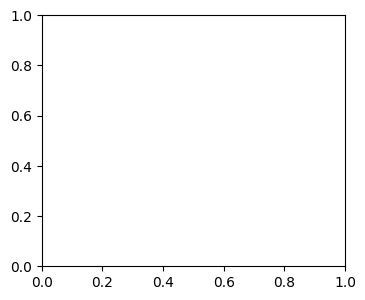

In [ ]:
import librosa.display
plt.figure(figsize=(18,15))

for i in range(4):
  plt.subplot(4,4,i+1)
  j = load(TrackSet_1[i])
  librosa.display.AdaptiveWaveplot(j[0], sr=3000)



In [ ]:
train_dataset =(
    tf.data.Dataset.from_tensor_slices((TrackSet_1)).map(map_data, num_parallel_calls=AUTOTUNE).shuffle(3).batch(BATCH_SIZE)
)

test_dataset=(
    tf.data.Dataset.from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

Network architecture


In [ ]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, type = 'encode', prefix = ''):
        super(Resnet1DBlock, self).__init__()

        if type == 'encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2, padding = "same", \
                                        name = prefix + 'conv1a')
            self.conv1b = layers.Conv1D(filters, kernel_size, 1, padding = "same", \
                                        name = prefix + 'conv1b')
            self.norm1a = tfa.layers.InstanceNormalization(name =  prefix + 'norm1a')
            self.norm1b = tfa.layers.InstanceNormalization(name =  prefix + 'norm1b')
        elif type == 'decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1, padding = "same", \
                                                name =  prefix + 'conv1a')
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1, padding = "same", \
                                                name =  prefix + 'conv1b')
            self.norm1a = tf.keras.layers.BatchNormalization(name =  prefix + 'norm1a')
            self.norm1b = tf.keras.layers.BatchNormalization(name =  prefix + 'norm1b')
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)



In [ ]:
class CVAE(tf.keras.Model):

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = (1, 90001), name = 'input_encoder'),

                layers.Conv1D(64, 1, 2, name = 'conv1_layer1'),
                Resnet1DBlock(64, 1, 'encode', prefix = 'res1_'),
                layers.Conv1D(128, 1, 2, name = 'conv1_layer2'),
                Resnet1DBlock(128, 1, 'encode', prefix = 'res2_'),
                layers.Conv1D(128, 1, 2, name = 'conv1_layer3'),
                Resnet1DBlock(128, 1, 'encode', prefix = 'res3_'),
                layers.Conv1D(256, 1, 2, name = 'conv1_layer4'),
                Resnet1DBlock(256, 1, 'encode', prefix = 'res4_'),

                layers.Flatten(name = 'flatten'),
                layers.Dense(latent_dim + latent_dim, name = 'dense'),
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = (latent_dim,), name = 'input_decoder'),
                layers.Reshape(target_shape = (1, latent_dim)),
                Resnet1DBlock(512, 1, 'decode', prefix = 'res1_'),
                layers.Conv1DTranspose(512, 1, 1, name = 'Conv1Trans_Layer1'),
                Resnet1DBlock(256, 1, 'decode', prefix = 'res2_'),
                layers.Conv1DTranspose(256, 1, 1, name = 'Conv1Trans_Layer2'),
                Resnet1DBlock(128, 1, 'decode', prefix = 'res3_'),
                layers.Conv1DTranspose(128, 1, 1, name = 'Conv1Trans_Layer3'),
                Resnet1DBlock(64, 1, 'decode', prefix = 'res4_'),
                layers.Conv1DTranspose(64, 1, 1, name = 'Conv1Trans_Layer4'),
                layers.Conv1DTranspose(90001, 1, 1, name = 'Conv1Trans_Layer5')
            ]
        )
@tf.function
def sample(self, esp=None):
      if eps is None:
        eps = tf.random.normal(shape=(200, self.latent_dim))
      return self.decode(eps, apply_sigmoid=True)
@tf.function
def encode(self,x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

@tf.function
def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps* tf.exp(logvar* .5)+ mean
@tf.function
def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs= tf.sigmoid(logits)
      return probs
    return logits


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2.* np.pi)
  return tf.reduce_sum(
      -.5* ((sample - mean)**2. * tf.exp(-logvar) + logvar + log2pi),
      axis = raxis
  )

In [ ]:
@tf.function
def compute_loss(model,x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

  logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

LOSS OPTIMIZATION

In [ ]:
from keras.backend import gradients
@tf.function
def train_step(model, x, optimizer):
   """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
   with tf.GradientTape() as tape:
      mean, logvar = model.encode(x)
      z = model.reparameterize(mean, logvar)
      x_logit = model.decode(z)
      cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
      logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
      logpz = log_normal_pdf(z, 0., 0.)
      logqz_x = log_normal_pdf(z, mean, logvar)

      loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
      reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_logit))

      total_loss = reconstruction_loss + loss_KL
      gradients = tape.gradient(total_loss, model.trainable_variables)

      optimizer.apply_gradients(zip(gradients, model.trainable_variables))




In [ ]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)

model = CVAE(latent_dim)

In [ ]:
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveplot(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()
# Pick a sample of the test set for g

In [ ]:
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

NameError: ignored

# Training model


In [ ]:
generate_and_save_images(model, 0, test_sample, 'jazz')
def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch,
                                                                                       elbo,
                                                                                       end_time - start_time
                                                                                      ))
        generate_and_save_images(model,
                                 epoch,
                                 test_sample,
                                 save)
train(train_dataset, test_dataset, model, 'jazz')

NameError: ignored

In [ ]:
pip install -q imageio

In [ ]:
import imageio

In [ ]:
anim_file_1 = 'jazz_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

NameError: ignored

#visualization

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)

#Generated music

In [ ]:
def inference(test_dataset, model):
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [ ]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)